## MediPal -- Agentic RAG -- Completed

### In this section, I will build an agent on top of the agentic retriever, and bring everything together under the name “MediPal.”
##### Design
1. Primary role: MediPal focuses on handling medical and clinical conversations based on retrieved documents. However, it can also talk about general, non-medical topics when needed.
2. Before it responds to users on medical topics, it runs a hallucination check after generating its answer. 
3. If the user is simply greeting, it immediately replies with a greeting without invoking the retriever tool.
4. In the future, MediPal will leverage multiple tools to support users in the medical domain. For example, it can summarize conversations and save them to Notion, or even help schedule an appointment with a doctor.

![](../screenshots/medipal_workflow2.PNG "")

In [2]:
import settings
from mytools import logging_print, draw_langgraph
from agentic_rag import rag_invoke, robust_binary_grader, AgentState, master_llm

import random
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, START, END

Login HuggingFace!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


Load tokenizer and base model done!
setup_retriever starts runing!
Login HuggingFace!
load_embedding_model starts runing!
load_embedding_model took 4.0499s
load_crossencoder starts runing!
load_crossencoder took 1.1284s
setup_retriever took 6.6822s


In [3]:
#Action node
def answer_generater(state: AgentState) -> AgentState:
    """ 
    Generate answer based on the retrieval documents.
    """
    query = state["query"]
    document = state["retrieved_doc"]
    logging_print(f"===Step {settings.STEP}===\n")    
    logging_print(f"Master_Agent: I am generating the answer based on the retrieved docs.\n")   
    prompt = PromptTemplate(
        template="""You are an assistant that answers questions **only** using the retrieved documents.
        ## Instructions
        - Read the provided documents carefully.
        - Answer the user query **strictly grounded in the documents**.  
        - If the documents do not contain enough information, reply with:
        "I'm sorry, the provided documents do not contain enough information to answer this question."
        - Do NOT add any outside knowledge or assumptions.
        ## Inputs
        Retrieved Documents:
        {document}
        User Query:
        {question}
        ## Output
        Provide a concise, plain-English answer based solely on the retrieved documents.
        """,
        input_variables=["document", "question"],
    )
    chain = prompt | master_llm | StrOutputParser()   
    raw = chain.invoke({"question": query, "document": document})
    logging_print(f"Real output: {raw}\n")        
    state["generation"] = str(raw)
    state["regenerate_counter"] += 1
    settings.STEP += 1
    return state 

In [4]:
#Action Node
def grade_greeting_query(state: AgentState) -> AgentState:
    """
    Determine whether a query is pure greeting.
    without relying on prior conversation context.
    """   
    query = state["query"]
    logging_print(f"===Step {settings.STEP}===\n")
    logging_print(f"""Master_Agent: Got a new query: "{query}"\nI will check if the query is pure greeting.\n""")     
   
    prompt = PromptTemplate(
        template="""
    You are a classifier that checks if a message is a **pure greeting**.

    Definition of pure greeting:
    - A short message whose sole purpose is to greet or say hello.
    - It may include polite questions or phrases like “How are you?”, “What’s up?”, 
    “Good to meet you”, “Nice to see you”, “How’s it going?”, etc.
    - It must NOT contain any request for information, task instructions, or other content.

    Your task:
    Given the user's input below, decide if it is a pure greeting.

    User input: {question}

    Return only a JSON object with a single key "score":
    - Output {{"score": "yes"}} if it is a pure greeting (even if it looks like a casual question such as “What’s up?”).
    - Output {{"score": "no"}} if it contains anything beyond a greeting.

    Do not add explanation or extra text.
    """,
        input_variables=["question"],
    )


    state["grade"] = robust_binary_grader(prompt=prompt, question=query)
    settings.STEP += 1
    return state

In [5]:
#Decision Node
def decide_greeting_query(state: AgentState) -> str:
    """ 
    If it's a greeting query, go to grader node for clinical checking.
    If it's not a greeting query, go to grader node for self-contained checking. 
    """
    if state['grade']["score"] == "yes":
        logging_print(f"Master_Agent: The query is just greeting. Greeting back.\n")
        return "greeting"
    else:
        logging_print(f"Master_Agent: The query is not greeting. Let's call RAG.\n")
        return "call_rag"

In [6]:
#Action Node
def greeting_back(state: AgentState) -> AgentState:
    """
    Greeting back    
    """
    query = state["query"]

    logging_print(f"===Step {settings.STEP}===\n")    
    logging_print(f"Master_Agent: I am greeting.\n")    
     
    prompt = PromptTemplate(
        template="""You are a polite greeter.
        When the user sends any message, you must ONLY greet them back in a friendly, natural way.
        Do NOT answer questions, give information, or add any extra content.
        Keep the reply short (one or two greeting sentences) and nothing else.

        User message: {message}
        Your entire reply must be ONLY the greeting, for example "Hello!" or "Hi, good morning!".
        """,
        input_variables=["message"],
    )
    chain = prompt | master_llm | StrOutputParser()    
    raw = chain.invoke({"message": query})
    logging_print(f"Real output: {raw}\n")      
    state["generation"] = str(raw)    
    settings.STEP = 1
    return state

In [18]:
#Action Node
def answer_normally(state: AgentState) -> AgentState:
    """
    Greeting back    
    """
    query = state["query"]

    logging_print(f"===Step {settings.STEP}===\n")    
    logging_print(f"Master_Agent: I am answering normal message.\n")    
     
    prompt = PromptTemplate(
        template="""You are a "Simple & Clear Answer" assistant.
    Your job: read the user's message and reply with a very simple, easy-to-understand answer.

    Rules:
    - Use plain English and common words.
    - Be direct. Answer the exact question first.
    - Keep it short: 1-2 short sentences maximum.
    - No jargon. If a term is necessary, add a 3-5 word explanation in parentheses.
    - No extra facts, no links, no emojis, no disclaimers, no small talk.
    - If the user asks for steps, give 3 or fewer bullet points, each 1 short line.
    - If the message is not a question (e.g., a statement or request), give a short, helpful response that matches the intent.

    User message: {message}

    Your entire reply must follow the rules above and contain only the answer.""",
        input_variables=["message"],
    )
    chain = prompt | master_llm | StrOutputParser()    
    raw = chain.invoke({"message": query})
    logging_print(f"Real output: {raw}\n")      
    state["generation"] = str(raw)    
    settings.STEP = 1
    return state

In [19]:
#Action Node
def rag_calling(state: AgentState) -> AgentState:
    """
    Call Agentic RAG to retrieve relevant documents.   
    """   
    logging_print(f"===Step {settings.STEP}===\n")  
    logging_print(f"Master_Agent: I am calling RAG.\n") 
    state = rag_invoke(state)
    logging_print(state)
    settings.STEP += 1
    return state

In [20]:
#Decision Node
def decide_retrieve_success(state: AgentState) -> str:
    """ 
    If rag retrieved relevant docs, go to generate answer.
    If there is no retrieval docs, save to memory 
    """
    if state['grade']["score"] == "yes":
        logging_print(f"Master_Agent: Let's generate the answer.\n")
        return "answer_generater"
    else:
        logging_print(f"Master_Agent: There is no relevant docs from RAG.\n")   
           
        return "answer_normally"

In [21]:
#Action Node
def grade_hallucination(state: AgentState) -> AgentState:
    """
    Determine whether the answer llm generated has hallucination.    
    """
    generation = state["generation"]    
    retrieval_doc = state["retrieved_doc"]

    logging_print(f"answer:{generation}\n")
    logging_print(f"document:{retrieval_doc}\n")

    logging_print(f"===Step {settings.STEP}===\n")  
    logging_print(f"Master_Agent: I am checking if the answer has hallucination.\n")
    prompt = PromptTemplate(
        template="""
    You are a classifier that checks if an **answer is fully supported by the provided document**.

    Definition of “fully supported”:
    - Every factual statement in the answer can be directly verified in the given document.
    - The answer contains **no hallucination**, speculation, or information that is absent from the document.
    - Minor rephrasing or summarizing of the document is acceptable as long as it remains faithful.

    Your task:
    Given the document and the answer below, decide if the answer is completely grounded in the document.

    Document:
    {document}

    Answer:
    {answer}

    Return only a JSON object with a single key "score":
    - Output {{"score": "yes"}} if the answer is fully supported by the document with no hallucination.
    - Output {{"score": "no"}} if any part of the answer is not supported by the document.

    Do not add explanation or extra text.
    """,
        input_variables=["document", "answer"],
    )
    state["grade"] = robust_binary_grader(prompt=prompt, answer=generation, document=retrieval_doc)
    settings.STEP += 1
    return state

In [22]:
#testing

test_list = [
    {"answer": "phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth.", "document":"phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. it is usually taken every 4 hours as needed. follow the directions on your prescription label or the package label carefully, and ask your doctor or pharmacist to explain any part you do not understand. take phenylephrine exactly as directed. do not take more or less of it or take it more often than prescribed by your doctor or directed on the label."},
    {"answer": "Phenylephrine is usually taken as needed. if your doctor has told you to take phenylephrine regularly, take the missed dose as soon as you remember it.","document":"before receiving amphotericin b lipid complex injection,tell your doctor and pharmacist if you are allergic to amphotericin b, any other medications, or any of the ingredients in amphotericin b lipid complex injection. "}         
]

for a in test_list:
    state = AgentState(generation=a["answer"], retrieved_doc=a["document"])

    result = grade_hallucination(state)
    logging_print(result)


answer:phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth.

document:phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. it is usually taken every 4 hours as needed. follow the directions on your prescription label or the package label carefully, and ask your doctor or pharmacist to explain any part you do not understand. take phenylephrine exactly as directed. do not take more or less of it or take it more often than prescribed by your doctor or directed on the label.

===Step 1===

Master_Agent: I am checking if the answer has hallucination.

Real output: {'score': 'yes'}

{'generation': 'phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth.', 'retrieved_doc': 'phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. it is usually taken every 4 hours as needed. follow the directions on your prescription label or the package label carefully, and ask your doctor or pharm

In [23]:
#Decision Node
def decide_hallucination(state: AgentState) -> str:
    """ 
    If the answer has hallucination, re-generate the answer.
    If it ground the retrieval document, save to memory 
    """
    if state['grade']["score"] == "yes":
        logging_print(f"Master_Agent: The answer is good now.\n")
        return "save_node"
    elif state["regenerate_counter"] <= 3:
        logging_print(f"Master_Agent: The answer has hallucination. I will generate another one.\n")
        return "answer_generater"
    else:
        settings.STEP = 1 #reset step  
        return "end"    

In [24]:
#Action Node
def save_to_memory(state: AgentState) -> AgentState:
    """ 
    Before End, save user's query and final answer to memory 
    """   
    logging_print(f"===Step {settings.STEP}===\n")
    logging_print("Master_Agent: I am saving the user query and answer to memory.\n")  
    logging_print(f"""User query: {state["query"]} - Generation: {state["generation"]}""") 
    #history = settings.SHORT_TERM_MEMORY.get_history(state["session_id"])

    settings.SHORT_TERM_MEMORY.add_message(session_id=state["session_id"], message=state["query"], msg_type="human")
    settings.SHORT_TERM_MEMORY.add_message(session_id=state["session_id"], message=state["generation"], msg_type="ai")
    settings.STEP = 1 # Reset the STEP 
    return state  

In [25]:
medipal_graph = StateGraph(AgentState)
# Nodes
medipal_graph.add_node("grade_greeting_node", grade_greeting_query)

medipal_graph.add_node("decide_greeting_router", lambda state: state)

medipal_graph.add_node("greeting_node", greeting_back)

medipal_graph.add_node("call_rag_node", rag_calling)

medipal_graph.add_node("decide_retrieve_success_router", lambda state: state)

medipal_graph.add_node("generate_answer_node", answer_generater)

medipal_graph.add_node("grade_hallucination_node", grade_hallucination)

medipal_graph.add_node("decide_hallucination", lambda state: state)

medipal_graph.add_node("save_node", save_to_memory)

medipal_graph.add_node("answer_normally_node", answer_normally)

#Edges
medipal_graph.add_edge(START, "grade_greeting_node")

medipal_graph.add_edge("grade_greeting_node", "decide_greeting_router")

medipal_graph.add_conditional_edges(
    source="decide_greeting_router",
    path=decide_greeting_query,
    path_map={
        "greeting": "greeting_node",
        "call_rag": "call_rag_node"
    }
)

medipal_graph.add_edge("call_rag_node", "decide_retrieve_success_router")

medipal_graph.add_conditional_edges(
    source="decide_retrieve_success_router",
    path=decide_retrieve_success,
    path_map={
        "answer_generater": "generate_answer_node",
        "answer_normally": "answer_normally_node"
    }
)

medipal_graph.add_edge("generate_answer_node", "grade_hallucination_node")

medipal_graph.add_edge("grade_hallucination_node", "decide_hallucination")

medipal_graph.add_conditional_edges(
    source="decide_hallucination",
    path=decide_hallucination,
    path_map={
        "save_node": "save_node",
        "answer_generater": "generate_answer_node",
        "end": END
    }
)

medipal_graph.add_edge("answer_normally_node", END)
medipal_graph.add_edge("greeting_node", END)
medipal_graph.add_edge("save_node", END)

medipal_app = medipal_graph.compile()

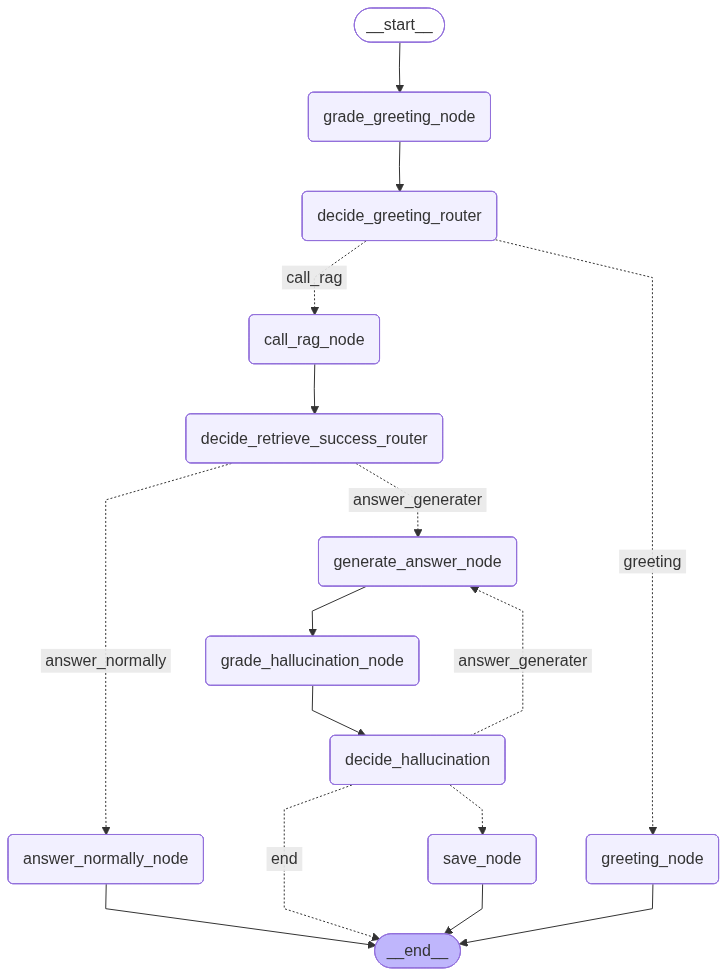

In [15]:
draw_langgraph(medipal_app)

In [16]:
draw_langgraph(medipal_app, False)

In [26]:
questions = [    
    "Is there anything I can assist you with?",    
    "Can I help you in any way, next?",
    "Do you have any questions?",  
    "Are you looking for any particular information?",
    "I am a Medicine Agentic RAG. I can help you get medical and clinical documents. Just tell me what you need?"
]

while True:
    user_input = input(random.choice(questions))
    if user_input.strip().lower() in ["end", "exit"]:
        break
    query = AgentState(query=user_input, session_id=1,wiki_used=False,brave_used=False,rewrite_counter=0,regenerate_counter=0)
    result = medipal_app.invoke(query)
    logging_print(f"result:{result}")
    

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


===Step 3===

Master_Agent: Got a new query: "can you tell me how to cook?"
I will check if the query is pure greeting.

Real output: {'score': 'no'}

Master_Agent: The query is not greeting. Let's call RAG.

===Step 4===

Master_Agent: I am calling RAG.

===Step 4===

Master_Agent: I will check if the query is self-contained.

Real output: {'score': 'yes'}

Master_Agent: The query is a self-contained one. We don't need to augment it. Let's check if it is a clinical query.

===Step 5===

Master_Agent: I am checking if the query is about medicine or clinical questions.

Real output: {'score': 'no'}

Master_Agent: The query is not clinical query. I can do nothing with it. 

===Step 6===

Master_Agent: TWe mainly handle information about medications and health care. Your question may be beyond my scope of work. I apologize for not being able to provide more information.
===Step 7===

Master_Agent: I am saving the user query and retrieved docs to memory.

{'session_id': 1, 'query': 'can yo

#### The responses make sense when I interacted with the MediPal by cmd input.
#### That means all components are working well.

#### But RAGAS is super tool for evaluating apps based on RAG system. I prepared about 30 Q&A pairs as evaluation dataset.
#### Below is an evaluation process with RAGAS. I will do answer_relevancy, faithfulness, context_precision, context_recall, answer_correctness matrics to see the performance.

In [14]:
qa_pairs = [
    {
        "question": "What conditions can phenylephrine help relieve?",
        "answer": "Phenylephrine can relieve nasal discomfort caused by colds, allergies, hay fever, and also help with sinus congestion and pressure."
    },
    {
        "question": "Does phenylephrine cure the cause of symptoms?",
        "answer": "No. Phenylephrine only relieves the symptoms but does not treat the underlying cause or speed up recovery."
    },
    {
        "question": "How does phenylephrine work in the body?",
        "answer": "Phenylephrine is a nasal decongestant. It works by reducing swelling of the blood vessels in the nasal passages."
    },
	{
        "question": "What allergies should you tell your doctor or pharmacist about before using pyrethrin and piperonyl butoxide shampoo?",
        "answer": "You should mention if you are allergic to pyrethrin, piperonyl butoxide, chrysanthemums, ragweed, any other medications, or any of the shampoo's ingredients."
    },
    {
        "question": "Why is it important to tell your doctor about other medications or supplements before using pyrethrin and piperonyl butoxide shampoo?",
        "answer": "Because prescription and nonprescription medications, vitamins, nutritional supplements, and herbal products may interact with the shampoo, so your doctor needs to know what you are taking or plan to take."
    },
    {
        "question": "What should you tell your doctor regarding your health history before using pyrethrin and piperonyl butoxide shampoo?",
        "answer": "You should tell your doctor if you have or have ever had skin conditions, or if you are pregnant, planning to become pregnant, or are breast-feeding."
    },
	{
        "question": "What should you do if someone swallows pyrethrin and piperonyl butoxide shampoo?",
        "answer": "Call your local poison control center immediately."
    },
    {
        "question": "What should you do if the person has collapsed or is not breathing after swallowing pyrethrin and piperonyl butoxide shampoo?",
        "answer": "Call local emergency services at 911 right away."
    },
    {
        "question": "Who should you contact first if pyrethrin and piperonyl butoxide shampoo is swallowed?",
        "answer": "You should first contact your local poison control center for instructions."
    },
	{
        "question": "What conditions can antipyrine and benzocaine otic help relieve?",
        "answer": "It can relieve ear pain and swelling caused by middle ear infections."
    },
    {
        "question": "Can antipyrine and benzocaine otic be used with antibiotics?",
        "answer": "Yes. It may be used along with antibiotics to treat an ear infection."
    },
    {
        "question": "How does the combination of antipyrine and benzocaine work?",
        "answer": "They are analgesics that work by reducing pain and discomfort in the ear."
    },
	{
        "question": "What is methylprednisolone injection used to treat?",
        "answer": "It is used to treat severe allergic reactions, multiple sclerosis, lupus, gastrointestinal disease, certain types of arthritis, and conditions affecting the blood, skin, eyes, nervous system, thyroid, kidneys, and lungs."
    },
    {
        "question": "Can methylprednisolone injection be used with other medications?",
        "answer": "Yes. It is sometimes used in combination with other medications to treat symptoms of low corticosteroid levels."
    },
    {
        "question": "What class of medications does methylprednisolone injection belong to?",
        "answer": "It belongs to a class of medications called corticosteroids."
    },
    {
        "question": "How does methylprednisolone injection help people with low corticosteroid levels?",
        "answer": "It replaces steroids that are normally produced naturally by the body."
    },
    {
        "question": "How does methylprednisolone injection treat other conditions?",
        "answer": "It works by reducing swelling and redness and by changing the way the immune system functions."
    }	
]

In [15]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import answer_relevancy, faithfulness, context_precision, context_recall, answer_correctness
import time

In [16]:
questions = []
model_answers = []
retrieved_contexts_lists: list[list] = []
reference_answers = []
for i, s in enumerate(qa_pairs):
    question = s["question"]
    answer = s["answer"]
    questions.append(question)
    reference_answers.append(answer)    
    query = AgentState(query=question, session_id=1,wiki_used=False,brave_used=False,rewrite_counter=0,regenerate_counter=0)
    result = medipal_app.invoke(query) 
    retrieved_contexts_lists.append([result["retrieved_doc"]])
    model_answers.append(result["generation"])   


data = Dataset.from_dict({
  "question": questions,                 # list[str]
  "answer": model_answers,               # list[str]
  "contexts": retrieved_contexts_lists,  # list[list[str]]
  "ground_truth": reference_answers      # list[str] (optional but needed for correctness)
})
# Everything is ready for evaluation
result = evaluate(
  data,
  metrics=[answer_relevancy, faithfulness, context_precision, context_recall, answer_correctness]
)

logging_print(result, print_out=True)   

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

{'answer_relevancy': 0.9281, 'faithfulness': 0.8235, 'context_precision': 0.8824, 'context_recall': 0.8235, 'answer_correctness': 0.7584}
